# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [121]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [122]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
}
check_packages(d)

[OK] numpy 1.26.4
[OK] matplotlib 3.9.2
[OK] sklearn 1.5.1


# Chapter 11 - Implementing a Multi-layer Artificial Neural Network from Scratch


### Overview

- [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)
  - [Single-layer neural network recap](#Single-layer-neural-network-recap)
  - [Introducing the multi-layer neural network architecture](#Introducing-the-multi-layer-neural-network-architecture)
  - [Activating a neural network via forward propagation](#Activating-a-neural-network-via-forward-propagation)
- [Classifying handwritten digits](#Classifying-handwritten-digits)
  - [Obtaining the MNIST dataset](#Obtaining-the-MNIST-dataset)
  - [Implementing a multi-layer perceptron](#Implementing-a-multi-layer-perceptron)
  - [Coding the neural network training loop](#Coding-the-neural-network-training-loop)
  - [Evaluating the neural network performance](#Evaluating-the-neural-network-performance)
- [Training an artificial neural network](#Training-an-artificial-neural-network)
  - [Computing the loss function](#Computing-the-loss-function)
  - [Developing your intuition for backpropagation](#Developing-your-intuition-for-backpropagation)
  - [Training neural networks via backpropagation](#Training-neural-networks-via-backpropagation)
- [Convergence in neural networks](#Convergence-in-neural-networks)
- [Summary](#Summary)

<br>
<br>

In [123]:
from IPython.display import Image
%matplotlib inline

# Modeling complex functions with artificial neural networks

...

## Single-layer neural network recap

In [124]:
# Image(filename='figures/11_01.png', width=600) 

<br>
<br>

## Introducing the multi-layer neural network architecture

In [125]:
# Image(filename='figures/11_02.png', width=600) 

In [126]:
# Image(filename='figures/11_03.png', width=500) 

<br>
<br>

## Activating a neural network via forward propagation

<br>
<br>

# Classifying handwritten digits

...

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [127]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [128]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

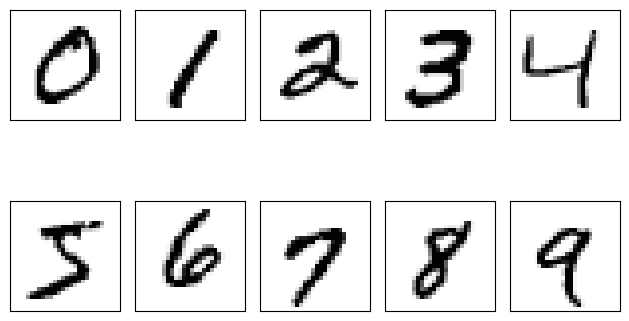

In [129]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

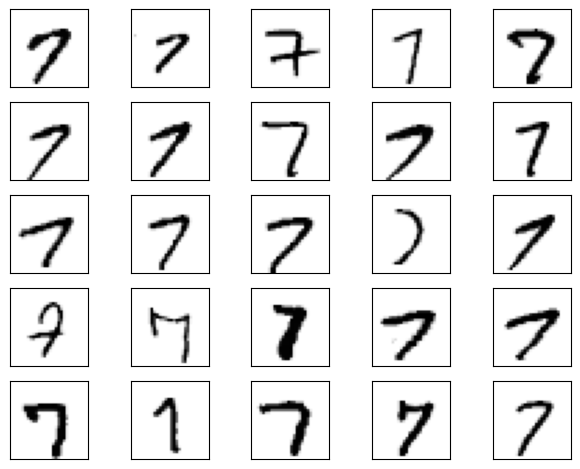

In [130]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [131]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [132]:
import numpy as np

In [133]:
##########################
### MODEL (2 hidden layers)
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

class NeuralNetMLP:

    # matches: NeuralNetMLP(num_features=..., num_hidden=..., num_classes=...)
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes
        rng = np.random.RandomState(random_seed)

        # Hidden layer 1: (num_hidden, num_features)
        self.weight_h1 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h1 = np.zeros(num_hidden)

        # Hidden layer 2: (num_hidden, num_hidden)
        self.weight_h2 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h2 = np.zeros(num_hidden)

        # Output layer: (num_classes, num_hidden)
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer 1
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):

        y_onehot = int_to_onehot(y, self.num_classes)

        # Output layer delta
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        # Gradients: output weights/bias
        d_loss__d_w_out = np.dot(delta_out.T, a_h2)
        d_loss__d_b_out = np.sum(delta_out, axis=0)

        # Hidden layer 2 delta
        d_loss__a_h2 = np.dot(delta_out, self.weight_out)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        # Gradients: hidden2 weights/bias
        d_loss__d_w_h2 = np.dot(delta_h2.T, a_h1)
        d_loss__d_b_h2 = np.sum(delta_h2, axis=0)

        # Hidden layer 1 delta
        d_loss__a_h1 = np.dot(delta_h2, self.weight_h2)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
        delta_h1 = d_loss__a_h1 * d_a_h1__d_z_h1

        # Gradients: hidden1 weights/bias
        d_loss__d_w_h1 = np.dot(delta_h1.T, x)
        d_loss__d_b_h1 = np.sum(delta_h1, axis=0)

        return (d_loss__d_w_out, d_loss__d_b_out,
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1)


In [134]:
model = NeuralNetMLP(
    num_features=28*28,
    num_hidden=500,
    num_classes=10
)


## Coding the neural network training loop

Defining data loaders:

In [135]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [136]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_,_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 9.9%


In [137]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _,_, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [138]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.2
Initial valid accuracy: 9.9%


In [139]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size
        )

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            (d_loss__d_w_out, d_loss__d_b_out,
             d_loss__d_w_h2, d_loss__d_b_h2,
             d_loss__d_w_h1, d_loss__d_b_h1) = model.backward(
                X_train_mini, a_h1, a_h2, a_out, y_train_mini
            )

            #### Update weights ####
            model.weight_h1  -= learning_rate * d_loss__d_w_h1
            model.bias_h1    -= learning_rate * d_loss__d_b_h1
            model.weight_h2  -= learning_rate * d_loss__d_w_h2
            model.bias_h2    -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out   -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)

        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.3f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%'
              f'| Valid MSE: {valid_mse:.3f}')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [140]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.036 | Train Acc: 82.96% | Valid Acc: 82.61%| Valid MSE: 0.036
Epoch: 002/050 | Train MSE: 0.026 | Train Acc: 87.49% | Valid Acc: 87.49%| Valid MSE: 0.026
Epoch: 003/050 | Train MSE: 0.022 | Train Acc: 88.79% | Valid Acc: 88.67%| Valid MSE: 0.022
Epoch: 004/050 | Train MSE: 0.019 | Train Acc: 89.83% | Valid Acc: 89.53%| Valid MSE: 0.020
Epoch: 005/050 | Train MSE: 0.018 | Train Acc: 90.63% | Valid Acc: 90.53%| Valid MSE: 0.018
Epoch: 006/050 | Train MSE: 0.017 | Train Acc: 91.15% | Valid Acc: 90.65%| Valid MSE: 0.017
Epoch: 007/050 | Train MSE: 0.016 | Train Acc: 91.57% | Valid Acc: 91.04%| Valid MSE: 0.016
Epoch: 008/050 | Train MSE: 0.015 | Train Acc: 91.72% | Valid Acc: 91.00%| Valid MSE: 0.016
Epoch: 009/050 | Train MSE: 0.015 | Train Acc: 92.17% | Valid Acc: 91.67%| Valid MSE: 0.015
Epoch: 010/050 | Train MSE: 0.014 | Train Acc: 92.51% | Valid Acc: 92.06%| Valid MSE: 0.014
Epoch: 011/050 | Train MSE: 0.013 | Train Acc: 92.66% | Valid Acc: 92.41%| Valid

## Evaluating the neural network performance

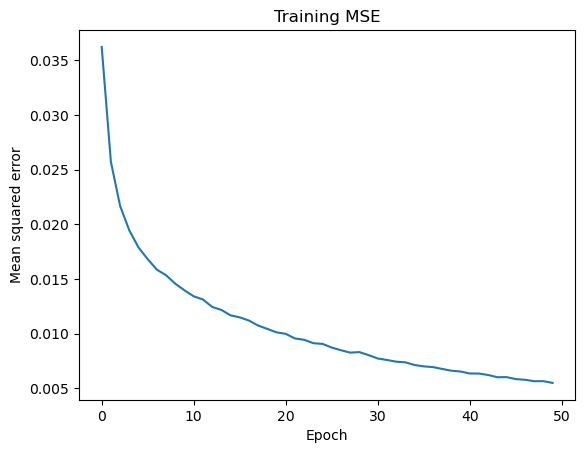

In [141]:
model_name = "NeuralNetMLP_2hidden"
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.title('Training MSE')
plt.savefig(f'{model_name}_training_mse_curve.png', dpi=300)
plt.show()

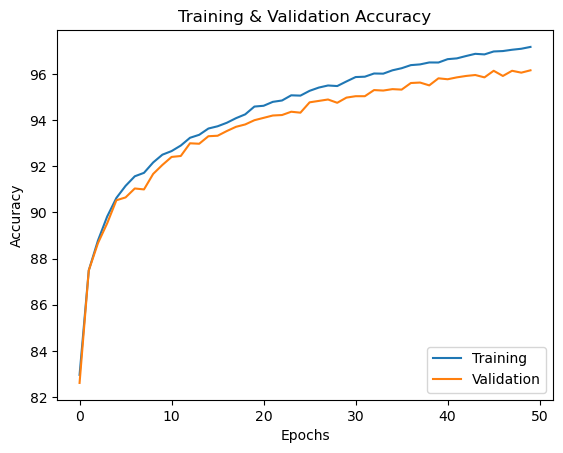

In [142]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')
plt.legend(loc='lower right')
plt.savefig(f'{model_name}_training_accuracy_curve.png', dpi=300)
plt.show()

In [143]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'Test MSE: {test_mse:.3f}')

Test accuracy: 96.09%
Test MSE: 0.007


Plot failure cases:

In [144]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_,_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

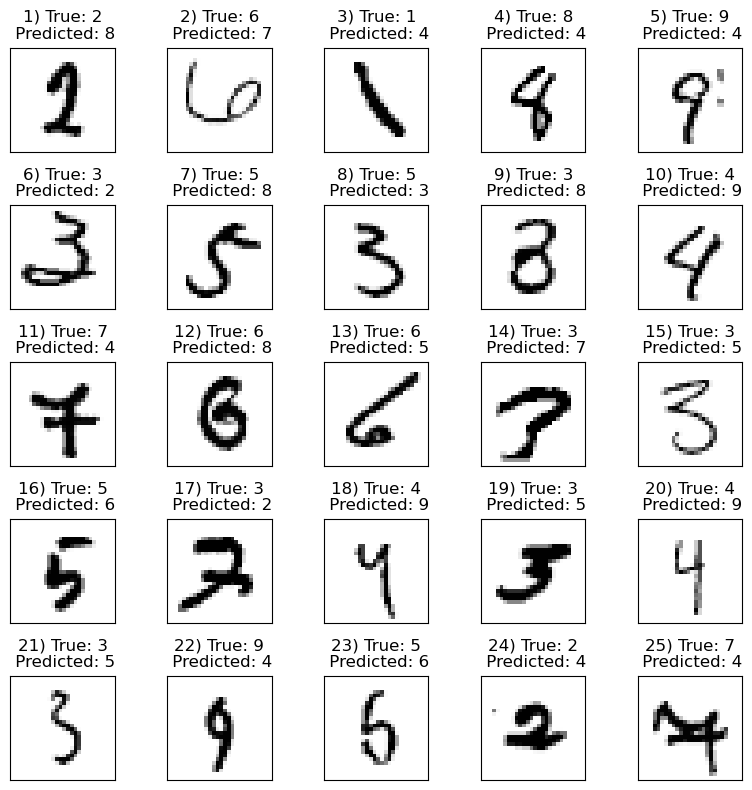

In [145]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

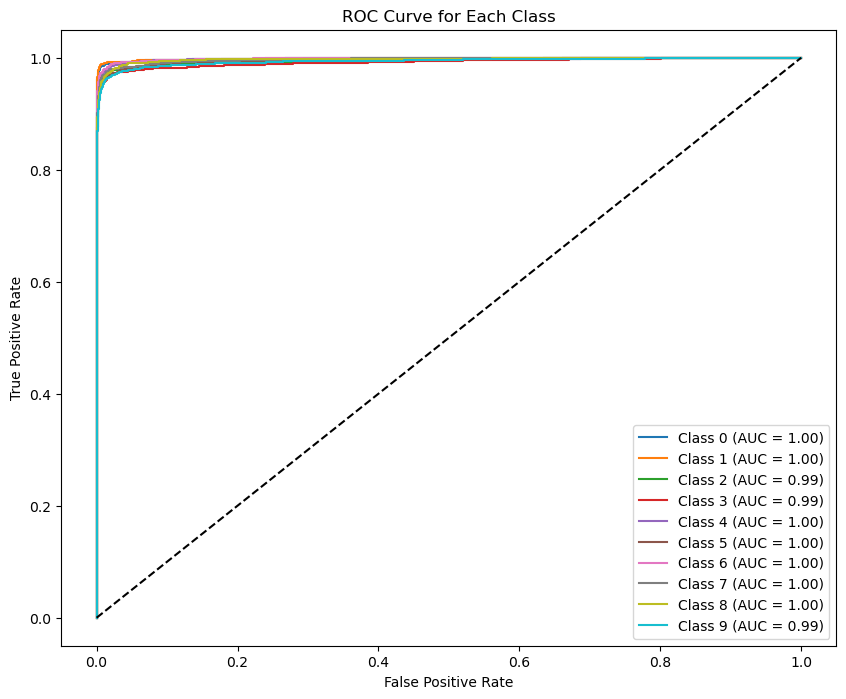

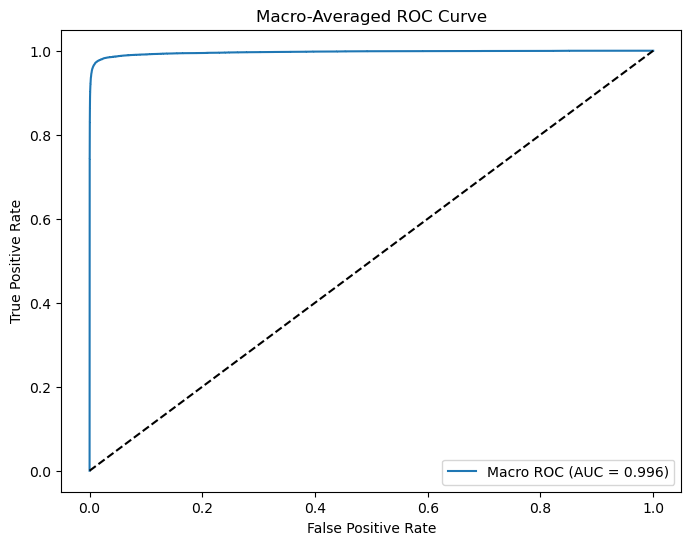

In [146]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

model_name = "NeuralNetMLP_2hidden"
# 1) Get model outputs (a_out) as "probas"
# Your forward returns: a_h1, a_h2, a_out
test_probas = model.forward(X_test)[-1]   # shape: (n_samples, 10)

# 2) Make y_test one-hot for ROC (shape: (n_samples, 10))
y_test_onehot = int_to_onehot(y_test, num_labels=10)

# (a) Per-Class ROC
plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], test_probas[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.savefig(f'{model_name}_roc_curve_each_class.png', dpi=300)
plt.show()

# (b) Macro-Averaged ROC Curve (micro-style flattening)
fpr_macro, tpr_macro, _ = roc_curve(y_test_onehot.ravel(), test_probas.ravel())
macro_roc_auc = auc(fpr_macro, tpr_macro)

plt.figure(figsize=(8, 6))
plt.plot(fpr_macro, tpr_macro, label=f'Macro ROC (AUC = {macro_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Macro-Averaged ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig(f'{model_name}_macro_roc_curve.png', dpi=300)
plt.show()


<br>
<br>

# Training an artificial neural network

...

## Computing the loss function

In [147]:
# Image(filename='figures/11_10.png', width=300) 

<br>
<br>

## Developing your intuition for backpropagation

...

## Training neural networks via backpropagation

In [148]:
# Image(filename='./figures/11_11.png', width=400) 

In [149]:
# Image(filename='figures/11_12.png', width=500) 

In [150]:
# Image(filename='figures/11_13.png', width=500) 

<br>
<br>

# Convergence in neural networks

In [151]:
# Image(filename='figures/11_14.png', width=500) 

<br>
<br>

...

# Summary

...

---

Readers may ignore the next cell.

In [152]:
! python ../.convert_notebook_to_script.py --input ch11.ipynb --output ch11.py

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'ch11.ipynb' matched no files
Traceback (most recent call last):
  File "c:\Users\stavf\OneDrive\שולחן העבודה\מדמח בן גוריון\תואר שני\למידה חישובית\ass3\machine-learning-book-main\.convert_notebook_to_script.py", line 78, in <module>
    cleanup(args.output)
  File "c:\Users\stavf\OneDrive\שולחן העבודה\מדמח בן גוריון\תואר שני\למידה חישובית\ass3\machine-learning-book-main\.convert_notebook_to_script.py", line 29, in cleanup
    with open(path, 'r', encoding="utf8") as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'ch11.py'
